In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기

In [3]:
# 저장된 데이터 불러오기

path = '/content/drive/MyDrive/teamC/코드/남훈/data.csv'

data = pd.read_csv(path)
data.head()

,Unnamed: 0,student_id,solve_date,p_num,p_level_mean,p_level_std,unique_seq_rate,seq_std,unique_name_rate,correct_rate_mean,correct_rate_std,type1_rate,type2_rate,type3_rate,type4_rate,score
0,1,I100008,2020-11-14,27.0,3.148148,0.863967,0.518519,4.471499,1.000000,53.055867,17.449039,0.0,0.518519,0.0,0.0,4.221825
1,2,I100008,2020-11-16,12.0,2.833333,0.577350,0.583333,4.407294,0.666667,53.233033,17.336359,0.0,0.583333,0.0,0.0,-0.780844
2,3,I100008,2020-11-18,20.0,3.450000,0.686333,0.500000,4.181413,0.750000,49.363020,13.081781,0.0,0.700000,0.0,0.0,-5.844156
3,4,I100008,2020-11-20,2.0,2.500000,0.707107,1.000000,4.949747,1.000000,63.278700,22.609032,0.0,0.000000,0.0,0.0,3.333333
4,5,I100008,2020-11-21,22.0,2.772727,0.528413,0.500000,5.038381,0.500000,57.228364,12.353609,0.0,0.590909,0.0,0.0,0.596491


In [4]:
data.shape

(237764, 16)

In [5]:
# 확인해보니 std관련되어서 null값이 있다. 따라서 해당되는 것들을 다시 제거해주자.

data = data.dropna(axis=0)
data.isnull().sum()

Unnamed: 0           0
student_id           0
solve_date           0
p_num                0
p_level_mean         0
p_level_std          0
unique_seq_rate      0
seq_std              0
unique_name_rate     0
correct_rate_mean    0
correct_rate_std     0
type1_rate           0
type2_rate           0
type3_rate           0
type4_rate           0
score                0
dtype: int64

In [6]:
data.shape # 확실히 null이 있는 행이 제거되었다.

(236503, 16)

In [7]:
# (X_features,y_target) 만들기

X_features = data.iloc[:, 3:-1]
y_target = data.iloc[:, -1]
X_features.head(1)

,p_num,p_level_mean,p_level_std,unique_seq_rate,seq_std,unique_name_rate,correct_rate_mean,correct_rate_std,type1_rate,type2_rate,type3_rate,type4_rate
0,27.0,3.148148,0.863967,0.518519,4.471499,1.0,53.055867,17.449039,0.0,0.518519,0.0,0.0


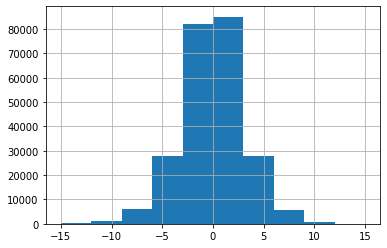

In [8]:
# 대략적으로 정규분포임으로 딱히 다른 처리를 하지 않고 진행해도 된다.

y_target.hist()

# 2. 데이터 분할

In [9]:
# 회귀(y값이 연속형변수)의 평가지표

from sklearn.metrics import mean_squared_error, mean_absolute_error

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSE: {0:.3F}, MAE: {1:.3F}'.format(rmse_val, mae_val))
    return (rmse_val, mae_val)

# 3-1. LinearRegression

RMSE: 2.946, MAE: 2.247


<BarContainer object of 2 artists>

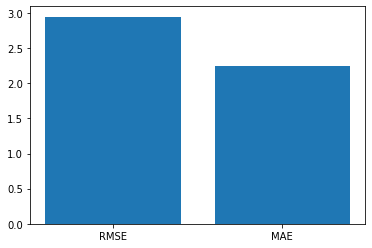

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# test/train 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

# Model
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

result = evaluate_regr(y_test, pred)
plt.bar(['RMSE','MAE'], result)

In [11]:
# 중요피쳐를 찾아내기 위해, 각 피쳐들을 스케일링해준다.
# 이후에 회귀계수의 절댓값이 클수록 중요피쳐로 생각해준다.

from sklearn.preprocessing import MinMaxScaler

total_data = pd.concat([X_features, y_target], axis=1)

scaler = MinMaxScaler()
scaler.fit(total_data)
trans_data = scaler.transform(total_data)

# numpy -> df
trans_data_df = pd.DataFrame(data=trans_data, columns=total_data.columns)
trans_data_df.head(1) # 0~1 사이의 값들을 가짐을 확인할 수 있다.

,p_num,p_level_mean,p_level_std,unique_seq_rate,seq_std,unique_name_rate,correct_rate_mean,correct_rate_std,type1_rate,type2_rate,type3_rate,type4_rate,score
0,0.021422,0.537037,0.305458,0.515287,0.234209,1.0,0.54359,0.294405,0.0,0.518519,0.0,0.0,0.640728


RMSE: 0.177, MAE: 0.153


<BarContainer object of 2 artists>

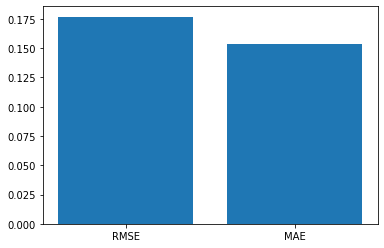

In [12]:
# 스케일링 이후, 재학습을 시도

# X_features : 'score'을 제외한 모든 열
X_features_df = trans_data_df.drop(['score'], axis=1, inplace=False)

# y_target = 'score'으로 두고 확인
y_target_df = trans_data_df.loc[:,'score']
y_target_df = y_target_df.reset_index(drop=True)

# test/train 분할
X_train_trans, X_test, y_train, y_test = train_test_split(X_features_df, y_target_df, test_size=0.3, random_state=0)

# Model
lr_reg1 = LinearRegression()
lr_reg1.fit(X_train, y_train)
pred = lr_reg1.predict(X_test)

result = evaluate_regr(y_test, pred)
plt.bar(['RMSE','MAE'], result) # 0~1로 숫자가 매우 작아, inf값이 나오기도 한다. 하지만 중요한 건 회귀계수의 크기이다.

In [13]:
# 표준화한 회귀계수의 절댓값

coef = lr_reg1.coef_
coef_abs = np.abs(coef)
coef_abs

array([0.00019268, 0.01906694, 0.09090696, 0.01941466, 0.00132042,
       0.00396172, 0.00098669, 0.00098039, 0.0349695 , 0.00019754,
       0.        , 0.        ])

In [14]:
# 회귀계수의 절댓값 크기 index

idx = coef_abs.argsort()[::-1]
idx

array([ 2,  8,  3,  1,  5,  4,  6,  7,  9,  0, 11, 10])

In [15]:
# 회귀계수의 절댓값을 큰 순서대로 정렬

coef = coef[idx]
coef_abs = coef_abs[idx]

In [16]:
# 회귀계수의 독립변수이름을 큰 순서대로 정렬

name = X_features_df.head(1).columns[idx].values
name

array(['p_level_std', 'type1_rate', 'unique_seq_rate', 'p_level_mean',
       'unique_name_rate', 'seq_std', 'correct_rate_mean',
       'correct_rate_std', 'type2_rate', 'p_num', 'type4_rate',
       'type3_rate'], dtype=object)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


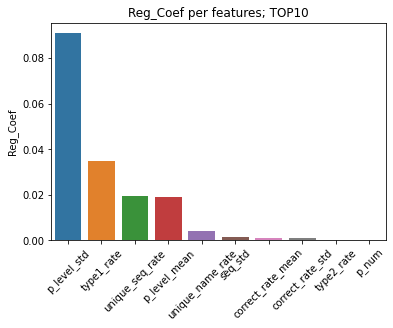

In [17]:
# top10

sns.barplot(name[0:10], coef_abs[0:10])
plt.xticks(rotation=45)
plt.ylabel('Reg_Coef')
plt.title('Reg_Coef per features; TOP10')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


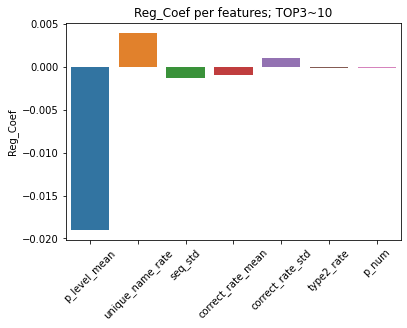

In [18]:
# top3~10

sns.barplot(name[3:10], coef[3:10])
plt.xticks(rotation=45)
plt.ylabel('Reg_Coef')
plt.title('Reg_Coef per features; TOP3~10')
plt.show()

# 3-2. Ensemble

In [19]:
# 데이터 분할

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# test/train 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

In [20]:
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print('###',model.__class__.__name__,'###')
    (rmse_val, mae_val) = evaluate_regr(y_test, pred)
    return (rmse_val, mae_val)

# end of function get_model_predict

In [22]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

result = []
# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=100)
gbm_reg = GradientBoostingRegressor(n_estimators=100)
xgb_reg = XGBRegressor(n_estimators=100)
lgbm_reg = LGBMRegressor(n_estimators=100)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    result.append(get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values))

### RandomForestRegressor ###
RMSE: 2.902, MAE: 2.208
### GradientBoostingRegressor ###
RMSE: 2.923, MAE: 2.230
[16:43:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSE: 2.924, MAE: 2.230
### LGBMRegressor ###
RMSE: 2.909, MAE: 2.220


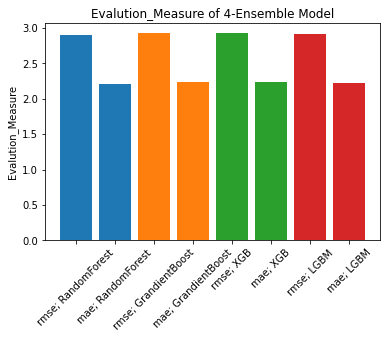

In [24]:
modelname = ['RandomForest','GrandientBoost','XGB','LGBM']

for i in range(len(result)):
  plt.bar(['rmse; {}'.format(modelname[i]),'mae; {}'.format(modelname[i])], result[i])
  plt.xticks(rotation=45)

plt.ylabel('Evalution_Measure')
plt.title('Evalution_Measure of 4-Ensemble Model')
plt.show()

중요피쳐 확인

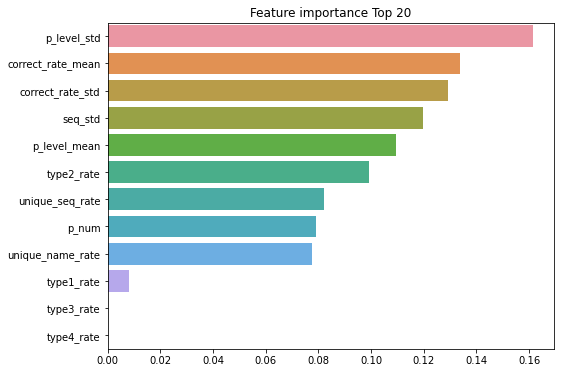

In [25]:
# 랜덤포레스트 

ftr_importances_values = rf_reg.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importance Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)

plt.show()

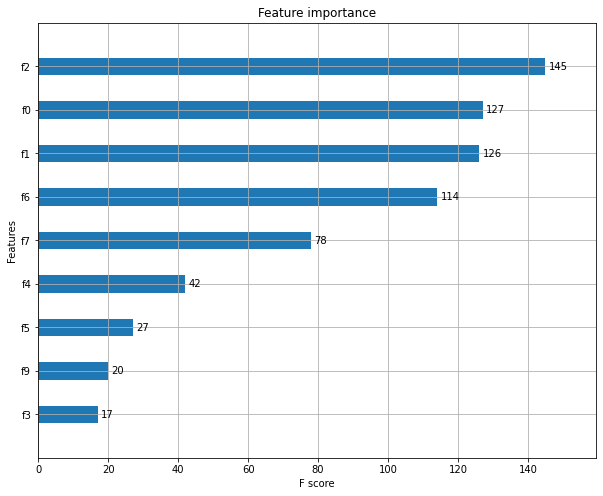

In [27]:
# XGB 

from xgboost import plot_importance

fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_reg, ax=ax, max_num_features=20, height=0.4)

In [29]:
X_features.head(1)

,p_num,p_level_mean,p_level_std,unique_seq_rate,seq_std,unique_name_rate,correct_rate_mean,correct_rate_std,type1_rate,type2_rate,type3_rate,type4_rate
0,27.0,3.148148,0.863967,0.518519,4.471499,1.0,53.055867,17.449039,0.0,0.518519,0.0,0.0


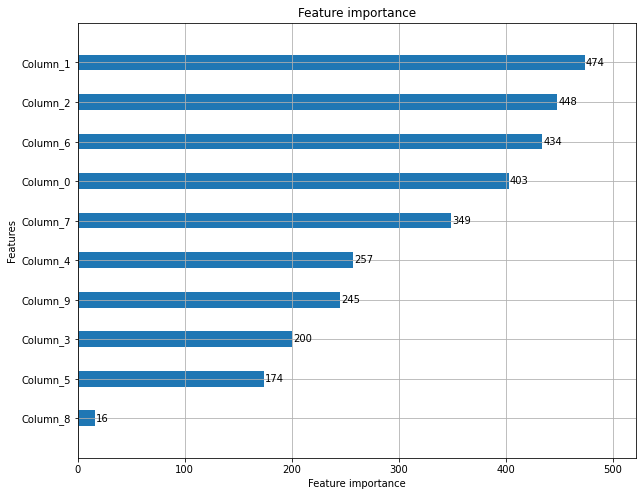

In [30]:
# LGBM 

from lightgbm import plot_importance

fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(lgbm_reg, ax=ax, max_num_features=20, height=0.4)

In [31]:
X_features.head(1)

,p_num,p_level_mean,p_level_std,unique_seq_rate,seq_std,unique_name_rate,correct_rate_mean,correct_rate_std,type1_rate,type2_rate,type3_rate,type4_rate
0,27.0,3.148148,0.863967,0.518519,4.471499,1.0,53.055867,17.449039,0.0,0.518519,0.0,0.0


In [ ]:
# 하이퍼파라미터 튜닝

import random

n_estimators = []
learning_rate = []
for i in range(10):
  n_estimators.append(random.randrange(1,10)*100)
  learning_rate.append(np.round(random.random(),1)/10)

# xgb
max_depth = [1,3,5,7]
eta = [0.1,0.3,0.5,0.7,0.9]
min_child_weight = [1,3,5,7]
colsample_bytree = [0.1,0.3,0.5,0.7,0.9]
reg_alpha = [0.01,0.03,0.05]

# lgbm
num_leaves = [32,64]
max_depth = [128,160]
min_child_samples = [60,100]
subsample = [0.8,1]

In [ ]:
# xgb-tunning

best_parm1 = {'max_depth':0, 'eta':0, 'min_child_weight':0, 'colsample_bytree':0, 'reg_alpha':0}
RMSE = 100

for a1 in max_depth:
  for a2 in eta:
    for a3 in min_child_weight:
      for a4 in colsample_bytree:
        for a5 in reg_alpha:
          xgb_reg = XGBRegressor(n_estimators=500, max_depth=a1, eta=a2, min_child_weight=a3, colsample_bytree=a4, reg_alpha=a5)
          temp = get_model_predict(xgb_reg, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)
          temp = temp[1]
          if temp < RMSE:
            RMSE = temp
            best_parm1['max_depth'] = a1
            best_parm1['eta'] = a2
            best_parm1['min_child_weight'] = a3
            best_parm1['colsample_bytree'] = a4
            best_parm1['reg_alpha'] = a5

xgb_reg = XGBRegressor(n_estimators=500, max_depth=best_parm1['max_depth'], eta=best_parm1['eta'], min_child_weight=best_parm1['min_child_weight'],
                       colsample_bytree=best_parm1['colsample_bytree'], reg_alpha=best_parm1['reg_alpha'])


print('-'*30)
print("best-parameter :", best_parm1)
print("RMSE value about best-parameter :", get_model_predict(xgb_reg,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True))

# pickle로 저장
import pickle
with open('/content/drive/MyDrive/xgbPt.pkl','wb') as f:
  pickle.dump(best_parm1,f)

In [ ]:
# lgb-tunning

best_parm2 = {'num_leaves':0, 'max_depth':0, 'min_child_samples':0, 'subsample':0}
RMSE = 100

for a1 in num_leaves:
  for a2 in max_depth:
    for a3 in min_child_samples:
      for a4 in subsample:
        lgbm_reg = LGBMRegressor(n_estimators=500, num_leaves=a1, eta=a2, min_child_samples=a3, subsample=a4)
        temp = get_model_predict(lgbm_reg, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)
        temp = temp[1]
        if temp < RMSE:
          RMSE = temp
          best_parm2['num_leaves'] = a1
          best_parm2['max_depth'] = a2
          best_parm2['min_child_samples'] = a3
          best_parm2['subsample'] = a4

lgbm_reg = LGBMRegressor(n_estimators=500, num_leaves=best_parm2['num_leaves'], max_depth=best_parm2['max_depth'], min_child_samples=best_parm2['min_child_samples'],
                         subsample=best_parm2['subsample'])


print('-'*30)
print("best-parameter :", best_parm2)
print("RMSE value about best-parameter :", get_model_predict(lgbm_reg, X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True))

# pickle로 저장
import pickle
with open('/content/drive/MyDrive/lgbmPt.pkl','wb') as f:
  pickle.dump(best_parm2,f)
     

이후에 다시 feature_importance를 뽑아본다.